# Surface Water-Mass Transformation

In this recipe, we compute surface water-mass transformation rates (both in the net and partitioned into contributions from heat and salt fluxes) for the southern ocean, south of 60S.

This recipe is model-agnostic. However, as diagnostics used for the surface water mass transformation calculation considerably differ between models. You should read the diagnostics in the `get_variables` function and add/remove according to your needs. An embedded dictionary automatically identifies the correct forcing, once the user points out which ocean model is being analyzed.

## 1. Defining surface water-mass transformation

The surface water-mass transformation framework described here follows [Newsom *et al* (2016)](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-15-0513.1) and [Abernathey *et al* (2016)](https://www.nature.com/articles/ngeo2749). Surface water-mass transformation may be defined as the volume flux into a given density class ($\sigma$) from lighter density classes ($\sigma'<\sigma$) due to surface buoyancy forcing. Integrated over a region of the ocean surface, this volume flux can be expressed as,

$$
\begin{equation}
\Omega(\sigma, t) = \frac{\partial}{\partial\sigma} \iint_{\sigma'<\sigma} \Big(\frac{\partial\sigma}{\partial\theta}\theta + \frac{\partial\sigma}{\partial S}S\Big) \, \mathrm{d}x \, \mathrm{d}y
\end{equation}
$$

where $t$ is time, and the terms in the integrand are the potential temperature ($\theta$) flux and salinity ($S$) flux components of the surface buoyancy flux. The linearity of this expression means we can extract the relative contributions of heat ($\Omega_\text{heat}$) and salinity ($\Omega_\text{fw}$) fluxes to surface water-mass transformation, highlighting driving mechanisms.

## 2. Requirements

**Analysis environment:** The conda/analysis3-25.05 (or later) module on NCI. This is available via the `xp65` project.

**Model diagnostics:** This notebook can be used for either MOM5 or MOM6 simulations. The `save_SWMT` function has an embedded dictionary that automatically identifies the correct diagnostics to be used for the water mass transformation in each model simulation. 

**Warning**: For ACCESS-OM2, this model sums up individual surface buyancy flux components, so it does not reproduce biases in the `net_sfc_heating` diagnostics (see this git issue from March 2019). 

For ACCESS-OM2 (MOM5) we need at least monthly resolution (in diag_table language...): `temp` or `surface_temp`, `salt` or `surface_salt`, `pme_net`, `sfc_salt_flux_restore`, `sfc_hflux_from_runoff`, `sfc_hflux_coupler`, `sfc_hflux_pme` and `frazil_3d_int_z` (although the latter is not strictly a surface flux, instead frazil heat fluxes are vertically integrated over the column; HOWEVER, this variable is highly surface intensified and, in most cases, conceptually relevant to what we want to know from SWMT analysis), plus some basic gridding information. 

For MOM6 we need at least monthly resolution (in diag_table language...): `wfo` (Water flux into the ocean), `salt_flux` (net salt flux into the ocean) and `hfds` (net heat flux).

In [1]:
import cartopy.crs as ccrs
import cf_xarray as cfxr
import cmocean as cm
# import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
import intake
cat = intake.cat.access_nri
import pdb

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45245,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:44911,Total threads: 1
Dashboard: /proxy/41265/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41983,


# Computing surface water mass transformation

We will do this by defining three functions. The first one loads the diagnostics needed (independently of the model). The second one **actually calculates the transformations**, and a third one does the density binning.

In [37]:
ds = cat['01deg_jra55v13_ryf9091'].search(variable="pme_net",frequency="1mon").to_dask(xarray_open_kwargs={"decode_timedelta": False})

In [40]:
ds['pme_net']

<xarray.DataArray 'pme_net' (time: 3360, yt_ocean: 2700, xt_ocean: 3600)> Size: 131GB
dask.array<concatenate, shape=(3360, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) object 27kB 1900-01-16 12:00:00 ... 2179-12-16 12:00:00
Attributes:
    long_name:      precip-evap into ocean (total w/ restore + normalize)
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [41]:
# Select time period and region
start_time = '2080-01-01'
end_time = '2080-12-31'
time_slice = slice(start_time, end_time)
lon_slice = slice(None, None)
lat_slice = slice(None, -59)
ds['pme_net'].cf.sel(X = lon_slice, Y = lat_slice, 
                     time = slice(start_time, end_time))

<xarray.DataArray 'pme_net' (time: 12, yt_ocean: 510, xt_ocean: 3600)> Size: 88MB
dask.array<getitem, shape=(12, 510, 3600), dtype=float32, chunksize=(1, 510, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
  * time      (time) object 96B 2080-01-16 12:00:00 ... 2080-12-16 12:00:00
Attributes:
    long_name:      precip-evap into ocean (total w/ restore + normalize)
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [27]:
def get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5'):

    # The models require different diagnostics to calculate the heat and salt fluxes.
    # mom6 outputs a net flux, whilst with mom5 we need to work with the separate components.
    model_vars = {
                    "mom5": {
                        "temperature":           ["temp"],
                        "salinity":              ["salt"],
                        "water_flux_into_ocean": ["pme_net"],
                        "salt_flux":             ["sfc_salt_flux_ice", "sfc_salt_flux_restore"],
                        "heat_flux":             ["sfc_hflux_coupler", "sfc_hflux_from_runoff",
                                                  "frazil_3d_int_z", "sfc_hflux_pme"],
                        "area":                  ["area_t"],
                        "maximum_depth":         ["ht"],
                    },
                    "mom6": {
                        "temperature":           ["thetao"],
                        "salinity":              ["so"],
                        "water_flux_into_ocean": ["wfo"],
                        "salt_flux":             ["salt_flux"],
                        "heat_flux":             ["hfds"],
                        "area":                  ["areacello"],
                        "maximum_depth":         ["deptho"],
                    }
                }
    # Load variables in a dictionary
    ds = {}
    keys = list(model_vars[model].keys())
    for k in keys:
        ds[k] = {}
        for var in model_vars[model][k]:
            if k in ["area", "maximum_depth"]:
                ds[k][var] = cat[expt].search(variable=var).to_dask(xarray_open_kwargs={
                    "decode_timedelta": False
                })
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice)
            else:
                try:
                    ds[k][var] = cat[expt].search(variable=var, frequency=freq).to_dask(
                        xarray_open_kwargs={
                            "chunks": {"time": "auto"}, 
                            "decode_timedelta": False
                        })
                    ds[k][var] = ds[k][var].cf.sel(
                        X = lon_slice, Y = lat_slice, 
                        time = slice(start_time, end_time))
                    
                    # Correct temperatures (if in K convert to C)
                    if k == 'temperature' and np.max(ds[k][var]) > 100:
                        ds[k][var] = ds[k][var] - 273.15
    
                    # If 3D field, grab the surface
                    if ds[k][var].cf.axes.get('Z'):
                        surface_z = ds[k][var].cf['Z'][0].values
                        ds[k][var] = ds[k][var].cf.sel(Z = 0, method = 'nearest')
                except:
                    raise Exception(f"Data loading error: var={var}, freq={freq}, start_time={start_time}, end_time={end_time}, expt={expt}")

    # Get temperature and salinity to calculate a couple other things we'll need later on
    CT = ds['temperature'][model_vars[model]['temperature'][0]]
    SP = ds['salinity'][model_vars[model]['salinity'][0]]

    # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP.cf['Y'])#.rename('pressure')

    # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP.cf['X'], SP.cf['Y'])#.rename('SA')

    # Calculate potential density
    pot_rho_1 = gsw.sigma1(SA, CT)#.rename('pot_rho_11')

    # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_1'] = pot_rho_1
    
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

In the function below to compute the salt transformation, note that the salt fluxes have units of (kg of salt)/m²/s, while β has units of kg / (g of salt), so we need to multiply the salt fluxes by 1000. The fresh water flux `pme_net` has units of (kg of water)/(m²/s) and needs to be multiplied by SSS to convert to (g of salt)/m²/s. This gives units of (kg of water)/m² for the salt_transformation but it will later be divided by time and density and be in m/s.

In [6]:
def compute_salt_transformation(ds):
    
    # First retrieve temperature and water_flux as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Multiply the water flux by absolute salinity to get it in the correct units
    water_flux_into_ocean = xr.Dataset(ds['water_flux_into_ocean']).to_array().squeeze().drop_vars('variable')
    water_flux_into_ocean = ds['SA'] * water_flux_into_ocean

    # Caculate the haline contraction coefficient
    haline_contraction = gsw.beta(ds['SA'], CT, ds['pressure']).rename('beta')

    # Calculate the net salt flux and multiply by 1000 to convert units
    net_salt_flux = xr.Dataset(ds['salt_flux']).to_array().sum(dim = 'variable') * 1000

    # Note that we also multiply pme_net by absolute salinity to have the correct units
    salt_transformation = haline_contraction * (water_flux_into_ocean - net_salt_flux) * ds['days_per_month']
    salt_transformation = salt_transformation.load()

    return salt_transformation

def compute_heat_transformation(ds):

    # First retrieve temperature as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Calculate the thermal expansion coefficient 
    thermal_expansion = gsw.alpha(ds['SA'], CT, ds['pressure']).rename('alpha')
    
    # Calculate the net surface heating
    net_surface_heating = xr.Dataset(ds['heat_flux']).to_array().sum(dim = 'variable')
    
    # Calculate the heat transformation
    heat_transformation = thermal_expansion * net_surface_heating * ds['days_per_month']
    heat_transformation = heat_transformation.load()

    return heat_transformation

Now we need to do the isopycnal re-binning

In [7]:
def isopycnal_bins(ds, salt_transformation, heat_transformation):
    
    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    isopycnal_bins = np.arange(31, 33.5, 0.02) 
    bin_bottoms = isopycnal_bins[:-1]    
    pot_rho_1 = ds['pot_rho_1']
    X = pot_rho_1.cf['longitude']
    Y = pot_rho_1.cf['latitude']
    
    binned_salt_transformation = xr.DataArray(np.zeros([len(bin_bottoms), len(Y), len(X)]), 
                                              coords = [bin_bottoms, Y, X], 
                                              dims = ['isopycnal_bins', Y.name, X.name], 
                                              name = 'salt_transformation')

    binned_heat_transformation = xr.DataArray(np.zeros([len(bin_bottoms), len(Y), len(X)]), 
                                              coords = [bin_bottoms, Y, X], 
                                              dims = ['isopycnal_bins', Y.name, X.name], 
                                              name = 'temp_transformation')
    
    binned_salt_transformation = binned_salt_transformation.chunk({'isopycnal_bins': 1})
    binned_heat_transformation = binned_heat_transformation.chunk({'isopycnal_bins': 1})
    
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum('time')
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i, :, :] = masked_transform

        masked_transform = (heat_transformation * bin_mask).sum('time')
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_heat_transformation[i, :, :] = masked_transform

    ndays = ds['days_per_month'].sum().values
    salt_transformation = binned_salt_transformation / ndays
    
    c_p = 3992.1 # J kg-1 degC-1
    heat_transformation = binned_heat_transformation / c_p / ndays

    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    heat_transformation = heat_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1]) / 2
    salt_transformation['isopycnal_bins'] = isopycnal_bin_mid
    heat_transformation['isopycnal_bins'] = isopycnal_bin_mid
    
    # Change the sign so that positive means conversion into denser water masses
    salt_transformation = -1 * salt_transformation
    heat_transformation = -1 * heat_transformation

    return salt_transformation, heat_transformation

# MOM5

In [8]:
# Change to your experiment of interest
expt = '01deg_jra55v13_ryf9091'
# freq = '1 monthly'
freq = '1mon'

# Select time period and region
start_time = '2080-01-01'
end_time = '2080-12-31'
time_slice = slice(start_time, end_time)
lon_slice = slice(None, None)
lat_slice = slice(None, -59)

In [9]:
cat["01deg_jra55v13_ryf9091"].search(variable="area_t").to_dask()

<xarray.Dataset> Size: 117MB
Dimensions:   (yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(675, 900), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(675, 900), meta=np.ndarray>
Data variables:
    area_t    (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(675, 900), meta=np.ndarray>
Attributes: (12/19)
    filename:                                 ocean_grid.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['area_t']
    intake_esm_attrs:filename:                ocean_grid.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,sea_floor_depth_below_...
    intake_esm_attrs:variable_cell_methods:   ,,,,,time: point,time: point,ti...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,days since ...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_grid.fx

In [28]:
ds = get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice, model = "mom5")
ds

{'temperature': {'temp': <xarray.DataArray 'temp' (time: 12, yt_ocean: 510, xt_ocean: 3600)> Size: 88MB
  dask.array<getitem, shape=(12, 510, 3600), dtype=float32, chunksize=(3, 300, 400), chunktype=numpy.ndarray>
  Coordinates:
    * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
      st_ocean  float64 8B 0.5413
    * time      (time) object 96B 2080-01-16 12:00:00 ... 2080-12-16 12:00:00},
 'salinity': {'salt': <xarray.DataArray 'salt' (time: 12, yt_ocean: 510, xt_ocean: 3600)> Size: 88MB
  dask.array<getitem, shape=(12, 510, 3600), dtype=float32, chunksize=(3, 300, 400), chunktype=numpy.ndarray>
  Coordinates:
    * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
      st_ocean  float64 8B 0.5413
    * time      (time) object 96B 2080-01-16 12:00:00 ... 2080-12-16 12:00:

In [29]:
ds["water_flux_into_ocean"]

{'pme_net': <xarray.DataArray 'pme_net' (time: 12, yt_ocean: 510, xt_ocean: 3600)> Size: 88MB
 dask.array<getitem, shape=(12, 510, 3600), dtype=float32, chunksize=(3, 510, 900), chunktype=numpy.ndarray>
 Coordinates:
   * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
   * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
   * time      (time) object 96B 2080-01-16 12:00:00 ... 2080-12-16 12:00:00
 Attributes:
     long_name:      precip-evap into ocean (total w/ restore + normalize)
     units:          (kg/m^3)*(m/sec)
     valid_range:    [-1000000.  1000000.]
     cell_methods:   time: mean
     time_avg_info:  average_T1,average_T2,average_DT}

In [34]:
ds["water_flux_into_ocean"]

{'pme_net': <xarray.DataArray 'pme_net' (time: 12, yt_ocean: 510, xt_ocean: 3600)> Size: 88MB
 dask.array<getitem, shape=(12, 510, 3600), dtype=float32, chunksize=(3, 510, 900), chunktype=numpy.ndarray>
 Coordinates:
   * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
   * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
   * time      (time) object 96B 2080-01-16 12:00:00 ... 2080-12-16 12:00:00
 Attributes:
     long_name:      precip-evap into ocean (total w/ restore + normalize)
     units:          (kg/m^3)*(m/sec)
     valid_range:    [-1000000.  1000000.]
     cell_methods:   time: mean
     time_avg_info:  average_T1,average_T2,average_DT}

In [13]:
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_dataarray()` method.

🚨 ⏰ **Note**: the `isopycnal_bins` method below might take ~10-15 minutes.

In [9]:
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('binned_salt_transformation_mom5.nc')
heat_transformation_binned.to_netcdf('binned_heat_transformation_mom5.nc')

In [11]:
salt_tr = xr.open_dataarray('binned_salt_transformation_mom5.nc', chunks = {'isopycnal_bins': 1})
heat_tr = xr.open_dataarray('binned_heat_transformation_mom5.nc', chunks = {'isopycnal_bins': 1})
net_tr = salt_tr + heat_tr

## Plotting

### Entire Southern Ocean south of 59S

In [12]:
area = xr.Dataset(ds['area']).to_array().squeeze().drop_vars('variable')

swmt = (area * net_tr / 1e6).cf.sum(['longitude', 'latitude'])
swmt_heat = (area * heat_tr / 1e6).cf.sum(['longitude', 'latitude'])
swmt_salt = (area * salt_tr / 1e6).cf.sum(['longitude', 'latitude'])

for da in [swmt, swmt_heat, swmt_salt]:
    da.attrs["units"] = "Sv"

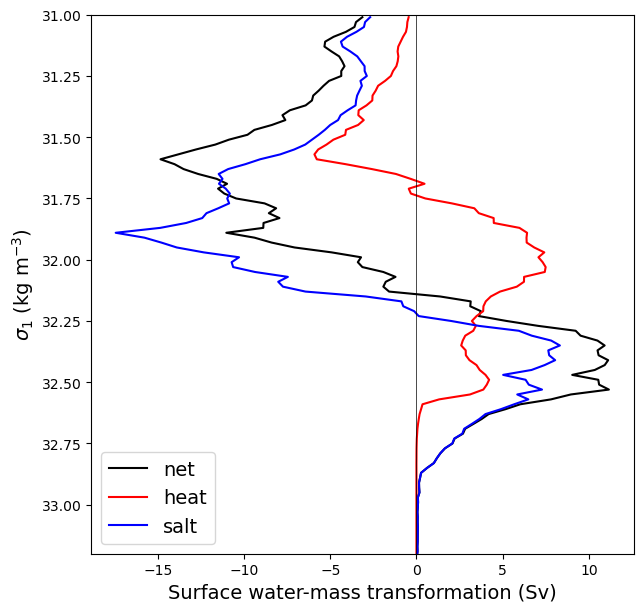

In [13]:
figure = plt.figure(figsize = (7, 7))

plt.plot(swmt, swmt['isopycnal_bins'], color = 'k', label='net')
plt.plot(swmt_heat, swmt['isopycnal_bins'], color = 'r', label='heat')
plt.plot(swmt_salt, swmt['isopycnal_bins'], color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth = 0.5)

plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 14)
plt.legend(loc = 3, fontsize = 14);

Here, the positive peak in the high density classes indicates a rate of subduction due to surface densification processes (predominantly freshwater fluxes associated with sea-ice processes in this case). The negative peak indicates upwelling rates.

### Antarctic shelf dense water formation

You might be interested in dense water formation on the Anarctic continental shelf. Below we've outlined a procedure whereby you can identify the density of subducting waters on the continental shelf, and map the locations where this sudbuction occurs.

You will need a way of masking for the continental shelf. You might just use a simple depth criterion, but here I define the shelf region using a mask that selects cells poleward of a continuous approximation of the 1000 m isobath surrounding Antarctica.

**Warning**: Shelf masking is model-specific, and can only be used for ACCESS-OM2 and PanAntartic simulations so far at 1/10th degree resolution. If you are using a different simulation you will have to calculate your own mask. 

In [14]:
def shelf_mask_isobath(var, model_dict):
    '''
    Masks ACCESS-OM2-01 and Pan-Antarctic variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison. Panan isobath created by Christina Schmidt"
    Only to be used with ACCESS-OM2-0.1 and Pan-Antarctic output!
    '''

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",     
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [15]:
depth = xr.Dataset(ds['maximum_depth']).to_array().squeeze()
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

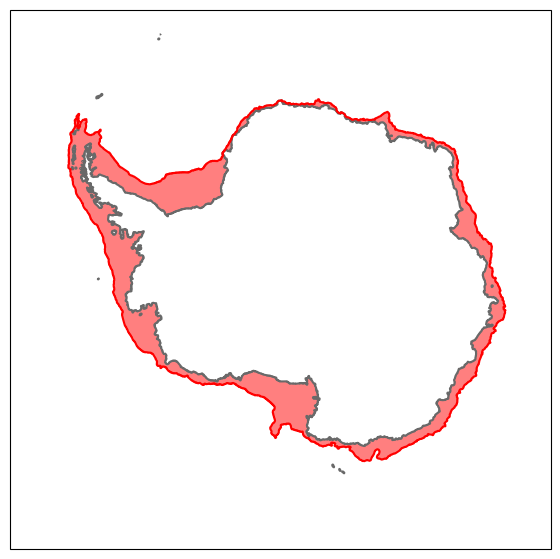

In [16]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(projection = ccrs.SouthPolarStereo())

ax.contourf(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask.where((shelf_mask == 1) & (land_mask == 0)),
            colors = 'red', alpha = 0.5, transform = ccrs.PlateCarree())
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey', transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'r', transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

In [17]:
area = xr.Dataset(ds['area']).to_array().squeeze().drop_vars('variable')

swmt_shelf = (net_tr * area / 1e6).where(shelf_mask == 1)
heat_shelf = (heat_tr * area / 1e6).where(shelf_mask == 1)
salt_shelf = (salt_tr * area / 1e6).where(shelf_mask == 1)

swmt_shelf_sum = swmt_shelf.cf.sum(['longitude', 'latitude'])
heat_shelf_sum = heat_shelf.cf.sum(['longitude', 'latitude'])
salt_shelf_sum = salt_shelf.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum]:
    da.attrs["units"] = "Sv"

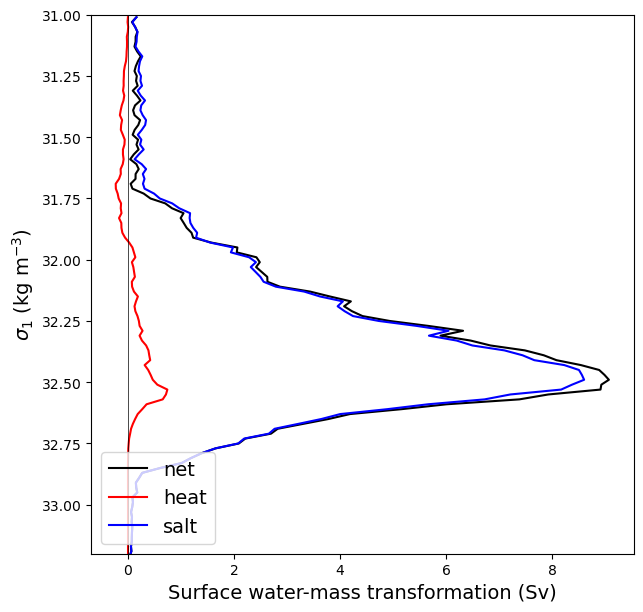

In [18]:
figure = plt.figure(figsize = (7, 7))

plt.plot(swmt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'k', label='net')
plt.plot(heat_shelf_sum, heat_shelf_sum['isopycnal_bins'], color = 'r', label='heat')
plt.plot(salt_shelf_sum, salt_shelf_sum['isopycnal_bins'], color = 'b', label='salt')
plt.plot([0, 0], [31.0, 33.2], 'k', linewidth = 0.5)

plt.ylim((33.2, 31.0))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 14)
plt.legend(loc = 3, fontsize = 14);

This shows us that continental shelf surface waters are made denser (almost entirely by sea-ice freshwater fluxes) and subduct away from the surface at a rate of over 8 Sv! Where does this happen? If we map the surface water-mass transformation rate across a chosen density class, we will be able to see where waters are subducting. We know from experience that the dense waters that overflow are best correlated with the transformation on the denser side of the peak, so let's choose $\sigma_1$ = 32.6 kg/m^3.

In [19]:
transformation_density = 32.6
shelf_subduction_plot = net_tr.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt = depth.cf['X']
swmt_yt = depth.cf['Y']

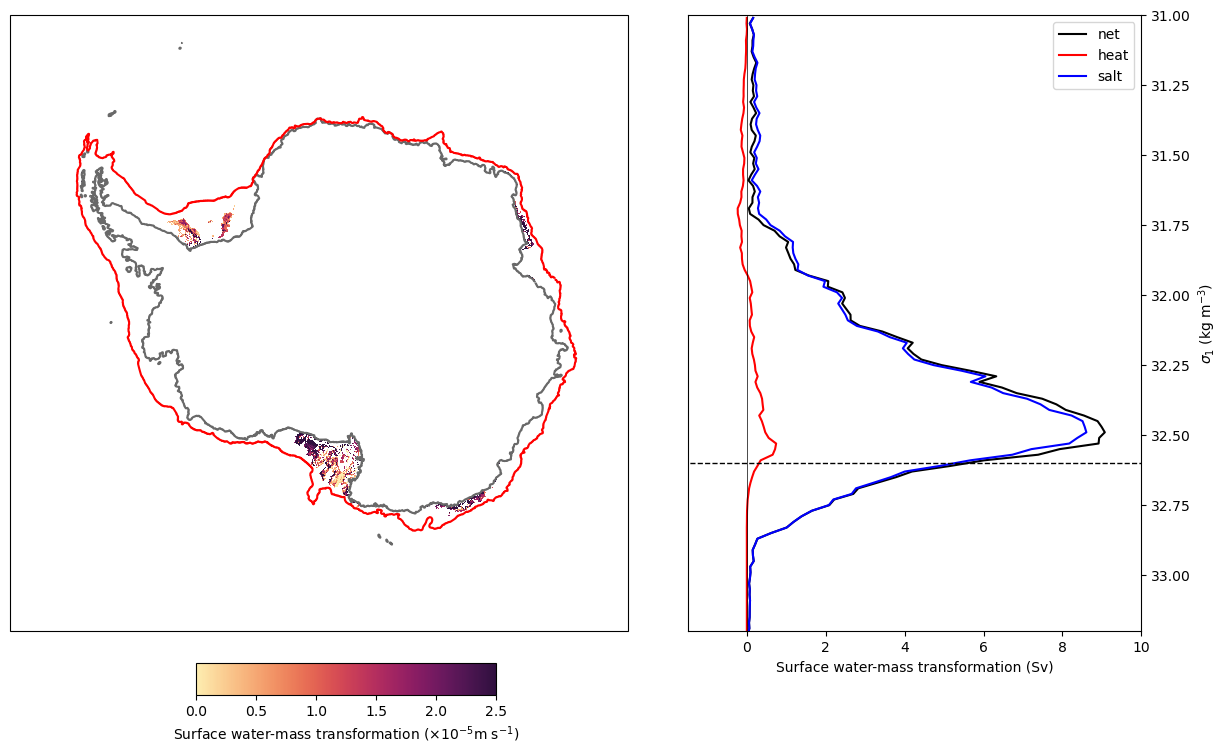

In [20]:
fig = plt.figure(1, figsize = (15, 8))
gs = gridspec.GridSpec(1, 2, width_ratios = [3, 2], wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection = ccrs.SouthPolarStereo()), plt.subplot(gs[1])
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey', transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'r', transform = ccrs.PlateCarree())

norm = mcolors.Normalize(vmin = 0, vmax = 2.5)
plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot,
                          vmin = 0, vmax = 2.5,
                          cmap = cm.cm.matter,
                          transform = ccrs.PlateCarree())

cax = fig.add_axes([0.27, 0.03, 0.2, 0.04])
cbar = plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3])
cbar.set_label(r'Surface water-mass transformation ($\times 10^{-5}$m s$^{-1}$)')

ax1.plot(swmt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'k', label='net')
ax1.plot(heat_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'r', label='heat')
ax1.plot(salt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'b', label='salt')
ax1.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
ax1.plot([-5, 15], [transformation_density, transformation_density], 'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-1.5, 10))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel(r'$\sigma_1$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mass transformation (Sv)')
ax1.legend();

# MOM6 example

In [21]:
# Change to your experiment of interest
expt = 'panant-01-zstar-ACCESSyr2'
session = cc.database.create_session()
freq = '1 monthly'

# Select time period and region
start_time = '2004-01-01'
end_time = '2004-12-31'
lon_slice = slice(None, None)
lat_slice = slice(None, -59)

In [22]:
ds = get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice, model = "mom6")

In [23]:
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

🚨 ⏰ **Note**: the `isopycnal_bins` method below might take ~10-15 minutes.

In [24]:
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('binned_salt_transformation_mom6.nc')
heat_transformation_binned.to_netcdf('binned_heat_transformation_mom6.nc')

In [25]:
salt_tr = xr.open_dataarray('binned_salt_transformation_mom6.nc', chunks = {'isopycnal_bins': 1})
heat_tr = xr.open_dataarray('binned_heat_transformation_mom6.nc', chunks = {'isopycnal_bins': 1})
net_tr = salt_tr + heat_tr

## Plotting

### Entire Southern Ocean south of 59S

In [26]:
area = xr.Dataset(ds['area']).to_array().squeeze().drop_vars('variable')

swmt = (area * net_tr / 1e6).cf.sum(['longitude', 'latitude'])
swmt_heat = (area * heat_tr / 1e6).cf.sum(['longitude', 'latitude'])
swmt_salt = (area * salt_tr / 1e6).cf.sum(['longitude', 'latitude'])

for da in [swmt, swmt_heat, swmt_salt]:
    da.attrs["units"] = "Sv"

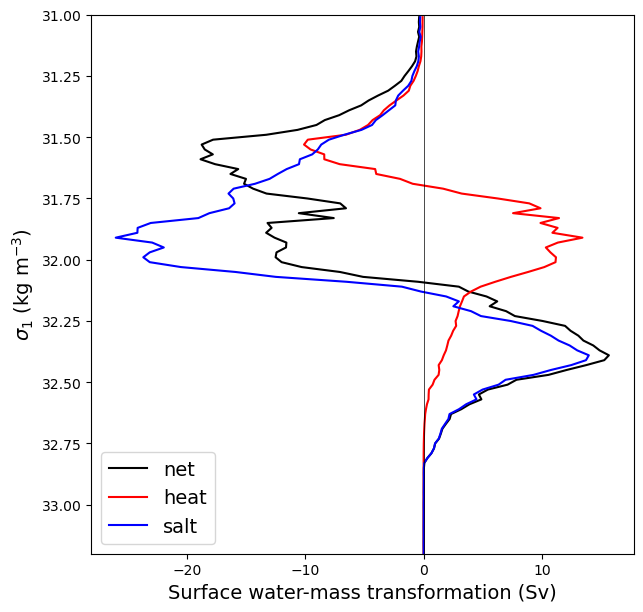

In [27]:
figure = plt.figure(figsize = (7, 7))

plt.plot(swmt, swmt['isopycnal_bins'], color = 'k', label='net')
plt.plot(swmt_heat, swmt['isopycnal_bins'], color = 'r', label='heat')
plt.plot(swmt_salt, swmt['isopycnal_bins'], color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth = 0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 14)
plt.legend(loc = 3, fontsize = 14);

### Antarctic shelf dense water formation

In [28]:
depth = xr.Dataset(ds['maximum_depth']).to_array().squeeze()
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

In [29]:
area = xr.Dataset(ds['area']).to_array().squeeze().drop_vars('variable')

swmt_shelf = (net_tr * area / 1e6).where(shelf_mask == 1)
heat_shelf = (heat_tr * area / 1e6).where(shelf_mask == 1)
salt_shelf = (salt_tr * area / 1e6).where(shelf_mask == 1)
swmt_shelf_sum = swmt_shelf.cf.sum(['longitude', 'latitude'])
heat_shelf_sum = heat_shelf.cf.sum(['longitude', 'latitude'])
salt_shelf_sum = salt_shelf.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum]:
    da.attrs["units"] = "Sv"

In [30]:
transformation_density = 32.6
shelf_subduction_plot = net_tr.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt = depth.cf['X']
swmt_yt = depth.cf['Y']

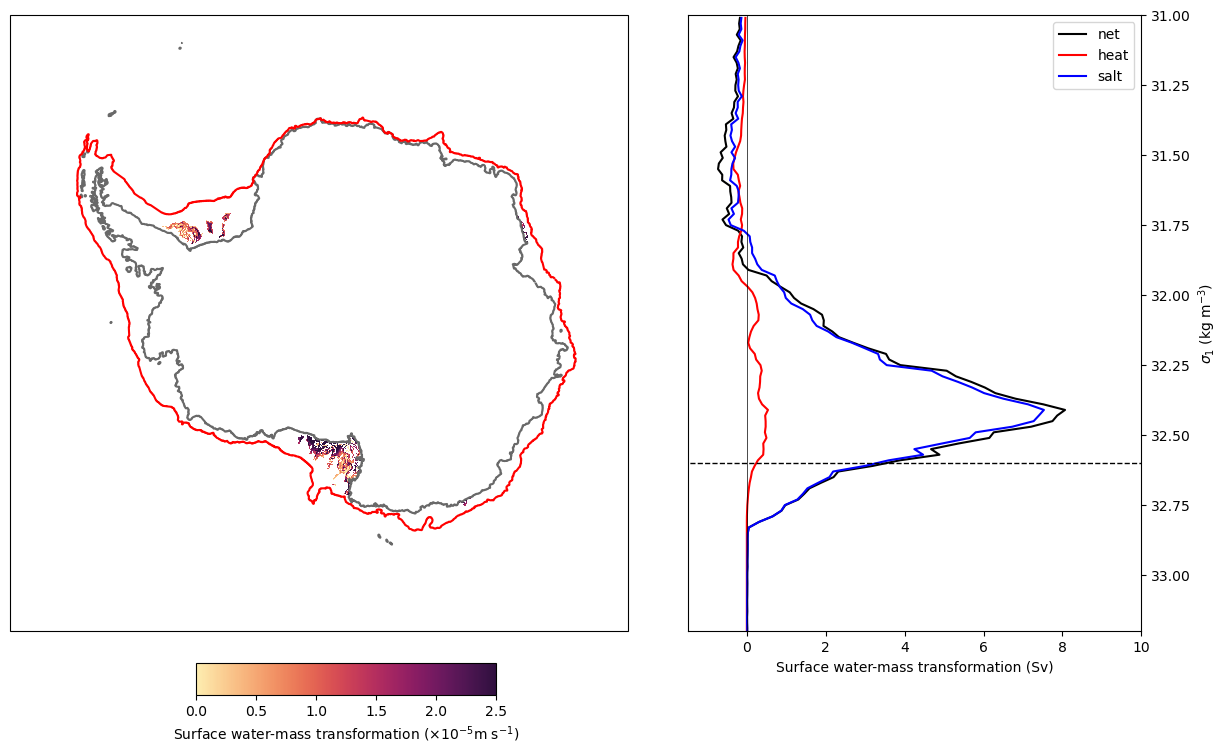

In [31]:
fig = plt.figure(1, figsize = (15, 8))
gs = gridspec.GridSpec(1, 2, width_ratios = [3, 2], wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection = ccrs.SouthPolarStereo()), plt.subplot(gs[1])
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey', transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'r', transform = ccrs.PlateCarree())

norm = mcolors.Normalize(vmin = 0, vmax = 2.5)
plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot,
                          vmin = 0, vmax = 2.5,
                          cmap = cm.cm.matter,
                          transform = ccrs.PlateCarree())

cax = fig.add_axes([0.27, 0.03, 0.2, 0.04])
cbar = plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3])
cbar.set_label(r'Surface water-mass transformation ($\times 10^{-5}$m s$^{-1}$)')

ax1.plot(swmt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'k', label='net')
ax1.plot(heat_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'r', label='heat')
ax1.plot(salt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'b', label='salt')
ax1.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
ax1.plot([-5, 15], [transformation_density, transformation_density], 'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-1.5, 10))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel(r'$\sigma_1$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mass transformation (Sv)')
ax1.legend();